In [1]:
import os
import itertools
import torch
import pandas as pd
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as pl
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, QuantileLoss
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


categorical_id = 6

time_df = pd.read_csv('../../../data/processed_electricity_data.csv')
time_df = time_df[time_df['id'].isin([f"MT_{str(i).zfill(3)}" for i in range(1, categorical_id)])]


valid_boundary=1315
train_data = time_df[time_df["days_from_start"] <= valid_boundary].copy()
val_data = time_df[time_df["days_from_start"] > valid_boundary].copy()
time_df = pd.concat([train_data, val_data]).sort_values(by=["categorical_id", "hours_from_start"]).reset_index(drop=True)
time_df['hours_from_start'] = time_df['hours_from_start'].astype(int)

max_prediction_length = 24
max_encoder_length = 7*24
training_cutoff = time_df["hours_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x.days_from_start <= valid_boundary],
    time_idx="hours_from_start",
    target="power_usage",
    group_ids=["categorical_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["categorical_id"],
    time_varying_known_reals=["hours_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['power_usage'],
    target_normalizer=GroupNormalizer(
        groups=["categorical_id"], transformation=None
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size*10, num_workers=0)


baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
print(MAE()(baseline_predictions.output, baseline_predictions.y))

/home/ubuntu/myenv/lib/python3.11/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/tmp/ipykernel_122736/28971419.py:61: UserWarning: In pytorch-forecasting models, from version 1.2.0, the default optimizer will be 'adam', in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
/home/ubuntu/myenv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['

tensor(9.1574, device='cuda:0')


In [2]:
import lightning.pytorch as pl
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet

# Path to checkpoint (replace with actual file name)
ckpt_path = "/home/ubuntu/Electricity Dataset/FE_Experiments/exp_variations_cat_id=6/lightning_logs/experiment_3/version_0/checkpoints/epoch=9-step=3970.ckpt"

# Load model from checkpoint
tft = TemporalFusionTransformer.load_from_checkpoint(ckpt_path)

# Print summary to verify
print(tft)

TemporalFusionTransformer(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'hours_from_start', 'target': 'power_usage', 'group_ids': ['categorical_id'], 'weight': None, 'max_encoder_length': 168, 'min_encoder_length': 168, 'min_prediction_idx': np.int64(26304), 'min_prediction_length': 24, 'max_prediction_length': 24, 'static_categoricals': ['categorical_id'], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['hours_from_start', 'day', 'day_of_week', 'month', 'hour'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['power_usage'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': False, 'lags': None, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': True, 'target_normalizer': GroupNormalizer(
  		method='standard',
  		grou

/home/ubuntu/myenv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/ubuntu/myenv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [3]:
# Ensure the model is in evaluation mode
tft.eval()

# Generate raw predictions
pred = tft.predict(validation, 
                   mode="raw", return_x=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/myenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x375 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

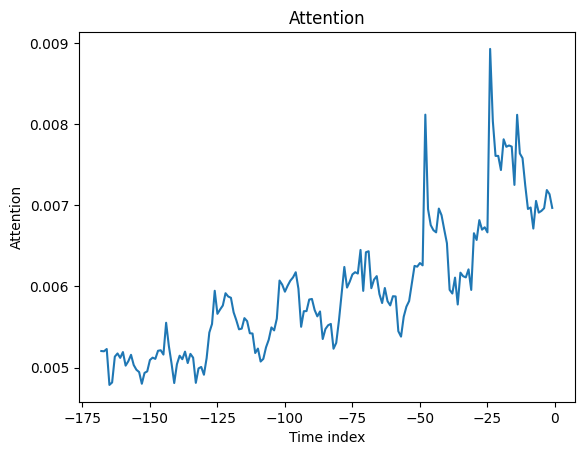

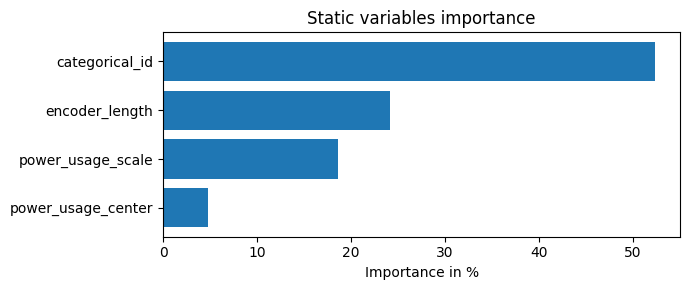

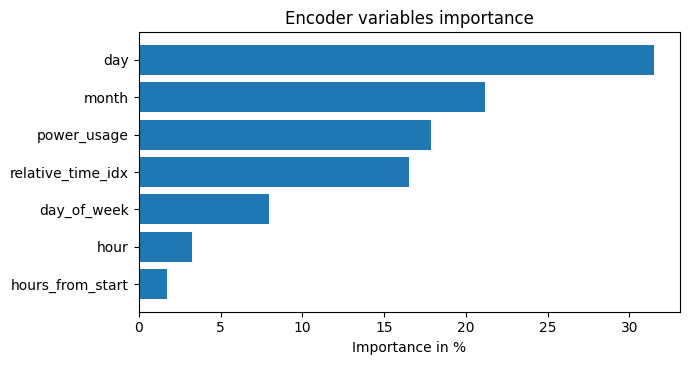

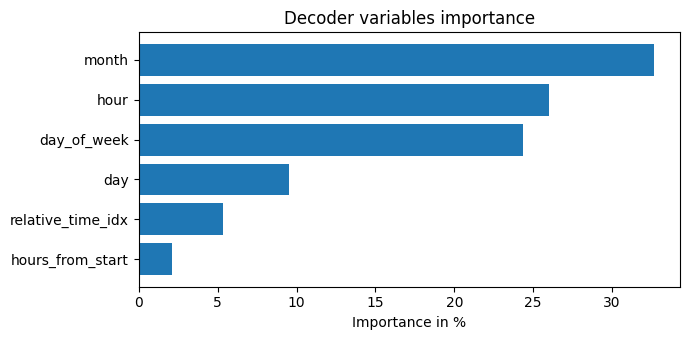

In [4]:
interpretation = tft.interpret_output(pred.output, reduction="sum")
tft.plot_interpretation(interpretation)

In [5]:
interpretation['attention'].shape

torch.Size([168])

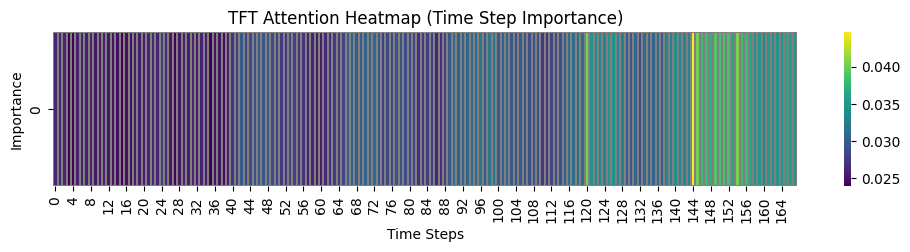

In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Extract attention values
attention_scores = interpretation["attention"].detach().cpu().numpy() if hasattr(interpretation["attention"], "detach") else np.array(interpretation["attention"])

# Reshape for visualization (if needed)
attention_matrix = attention_scores.reshape(1, -1)  # Convert to 2D (1-row matrix)

plt.figure(figsize=(12, 2))
sns.heatmap(attention_matrix, cmap="viridis", linewidths=0.1, linecolor="gray", annot=False, cbar=True)
plt.xlabel("Time Steps")
plt.ylabel("Importance")
plt.title("TFT Attention Heatmap (Time Step Importance)")
plt.show()


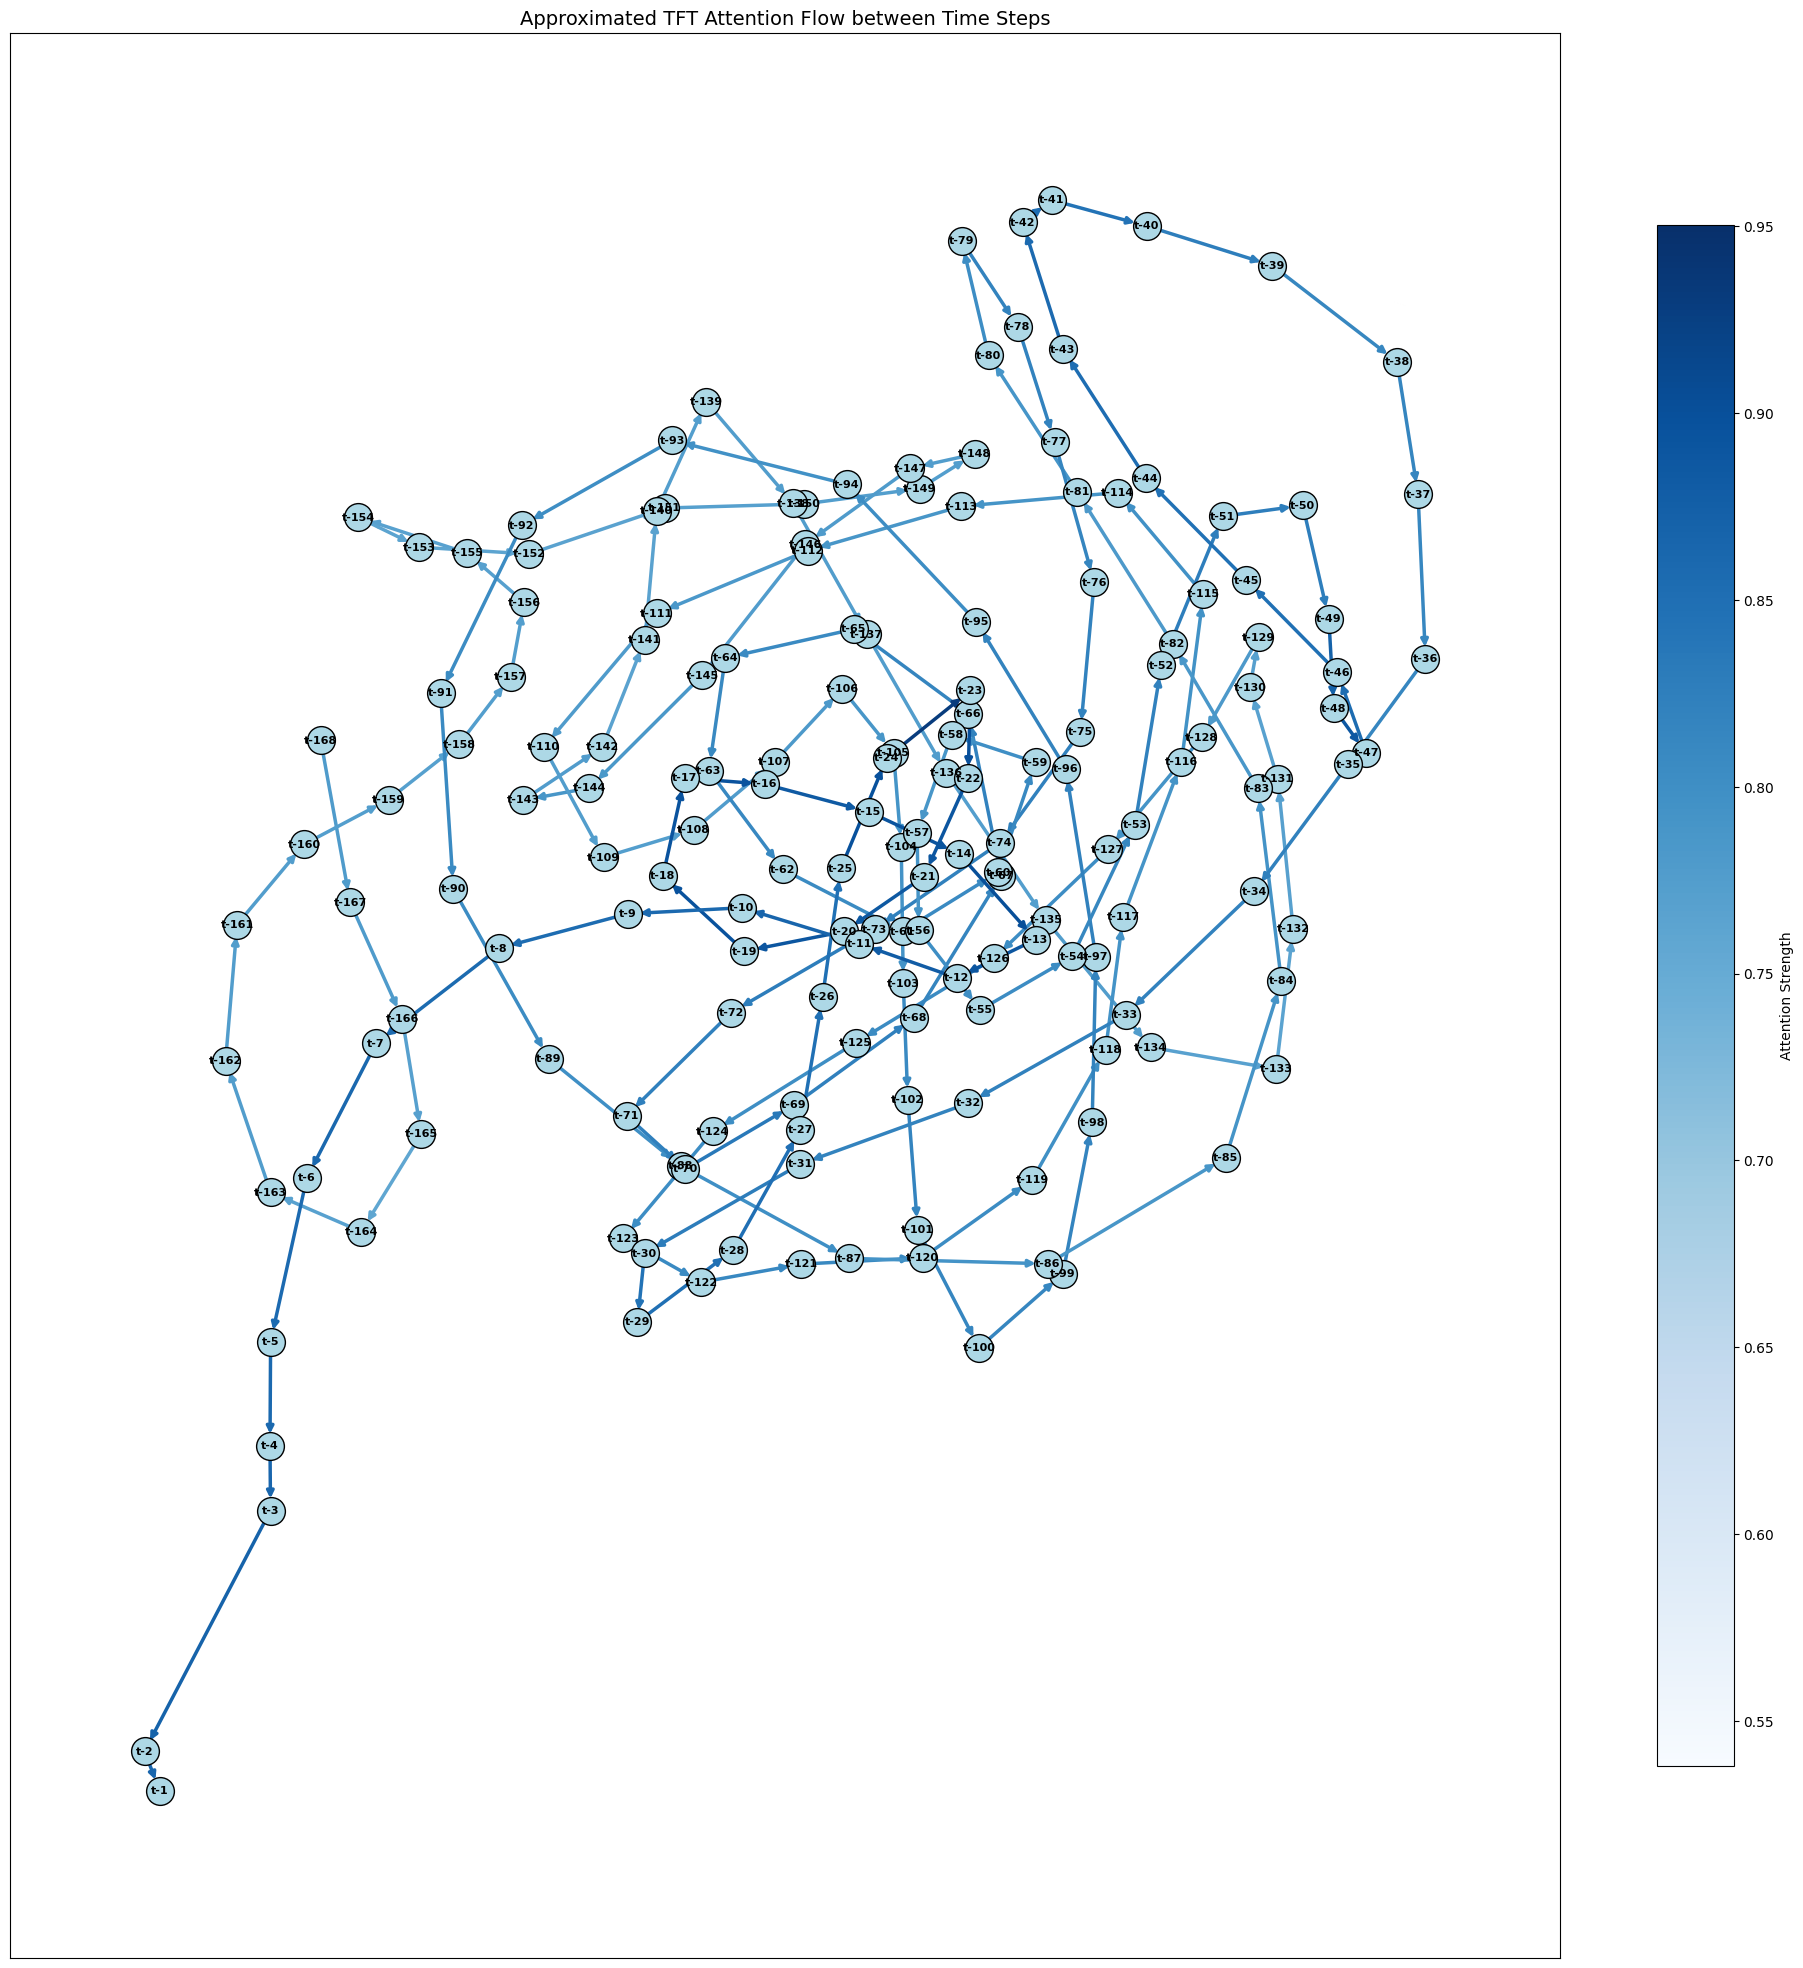

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_graph(attention_scores):
    """
    Plots a directed graph of TFT attention flow between time steps.
    - Nodes represent time steps.
    - Edges represent the strength of attention between consecutive time steps.
    - Darker edges indicate stronger attention weights.
    """
    G = nx.DiGraph()
    num_steps = len(attention_scores)

    # Normalize weights for better visualization
    max_weight = max(attention_scores) if max(attention_scores) > 0 else 1
    min_weight = min(attention_scores) if min(attention_scores) < 0 else 0

    # Add edges with approximate transition weights
    for i in range(num_steps - 1):
        weight = (attention_scores[i] + attention_scores[i + 1]) / 2  # Approximate transition weight
        normalized_weight = (weight - min_weight) / (max_weight - min_weight + 1e-6)  # Normalize between 0-1
        G.add_edge(f"t-{num_steps-i}", f"t-{num_steps-i-1}", weight=normalized_weight)

    # Graph layout
    pos = nx.spring_layout(G, seed=42)
    
    # Get edge weights for coloring
    edges = G.edges(data=True)
    weights = [d["weight"] for (_, _, d) in edges]

    # Set up figure
    plt.figure(figsize=(25, 25))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", edgecolors="black", node_size=400)

    # Draw edges with improved color mapping (darker edges)
    cmap = plt.cm.Blues  # Darker blues indicate stronger attention
    edges_drawn = nx.draw_networkx_edges(G, pos, edge_color=weights, edge_cmap=cmap, edge_vmin=0, edge_vmax=1, width=2.5)

    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black", font_weight="bold")

    # Add a colorbar legend for edge weights
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.8)
    cbar.set_label("Attention Strength")

    plt.title("Approximated TFT Attention Flow between Time Steps", fontsize=14)
    plt.show()

# Call function
plot_attention_graph(attention_scores)


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio

def create_attention_gif(attention_scores, filename="attention_evolution.gif"):
    """
    Generates an animated heatmap of TFT attention scores over time.
    """
    num_frames = len(attention_scores)
    frames = []
    
    for i in range(num_frames):
        fig, ax = plt.subplots(figsize=(12, 2))
        sns.heatmap(np.expand_dims(attention_scores[: i + 1], axis=0), cmap="Reds", cbar=False, ax=ax)
        ax.set_xticks(range(i + 1))
        ax.set_xticklabels([f"t-{num_frames - j}" for j in range(i + 1)], rotation=90)
        ax.set_yticks([])
        ax.set_title(f"Attention Evolution at t-{num_frames-i}")

        # Save frame
        fig.canvas.draw()
        frame = np.array(fig.canvas.renderer.buffer_rgba())
        frames.append(frame)
        plt.close(fig)
    
    # Save as GIF
    imageio.mimsave(filename, frames, duration=0.5)
    print(f"GIF saved as {filename}")

# Call function
create_attention_gif(attention_scores)


GIF saved as attention_evolution.gif


In [9]:
import plotly.graph_objects as go

def plot_attention_sankey(attention_scores):
    """
    Creates a Sankey diagram where:
    - Each node represents a time step.
    - Width of edges represents attention weight.
    """
    num_steps = len(attention_scores)
    
    source = []
    target = []
    values = []

    # Create flow connections between consecutive time steps
    for i in range(num_steps - 1):
        source.append(i)
        target.append(i + 1)
        values.append(attention_scores[i])

    # Create the Sankey plot
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=[f"t-{num_steps - i}" for i in range(num_steps)]
        ),
        link=dict(
            source=source,
            target=target,
            value=values,
            color="rgba(31, 119, 180, 0.6)"  # Adjust transparency for aesthetics
        )
    ))

    fig.update_layout(title_text="TFT Attention Flow (Sankey Diagram)", font_size=10)
    fig.show()

# Call function
plot_attention_sankey(attention_scores)


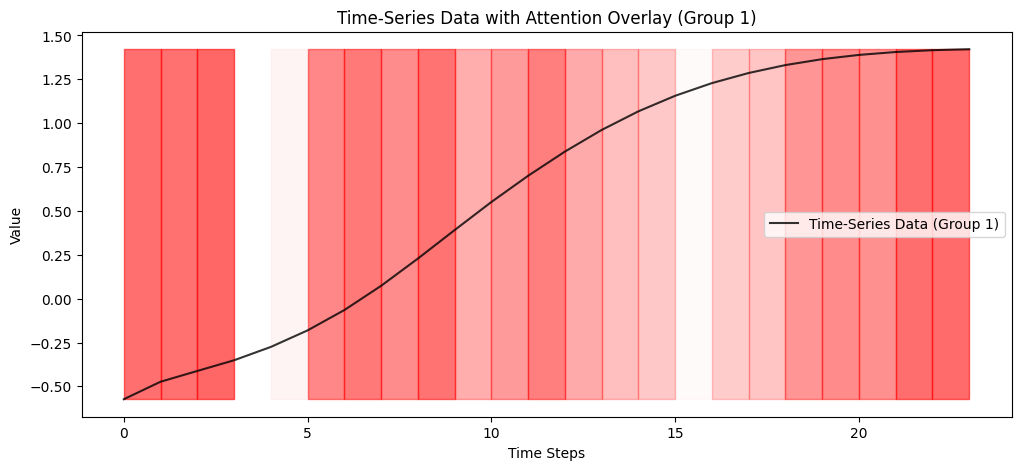

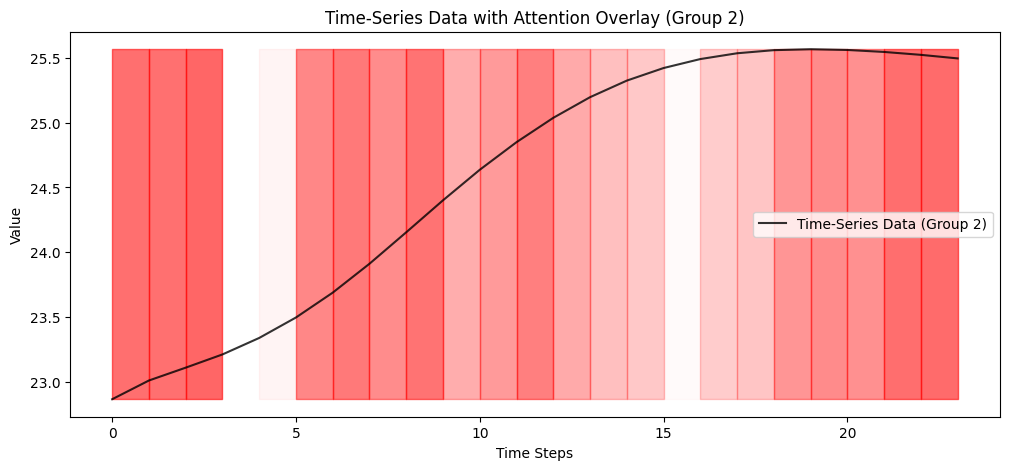

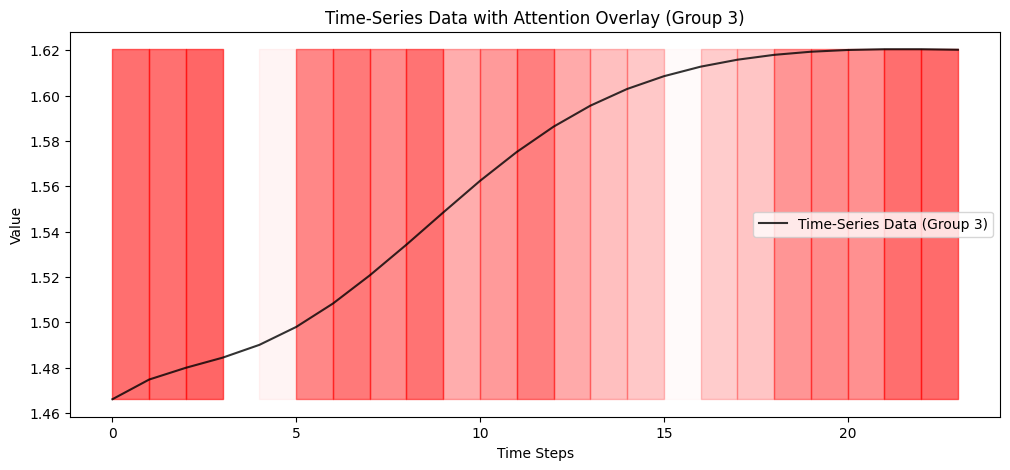

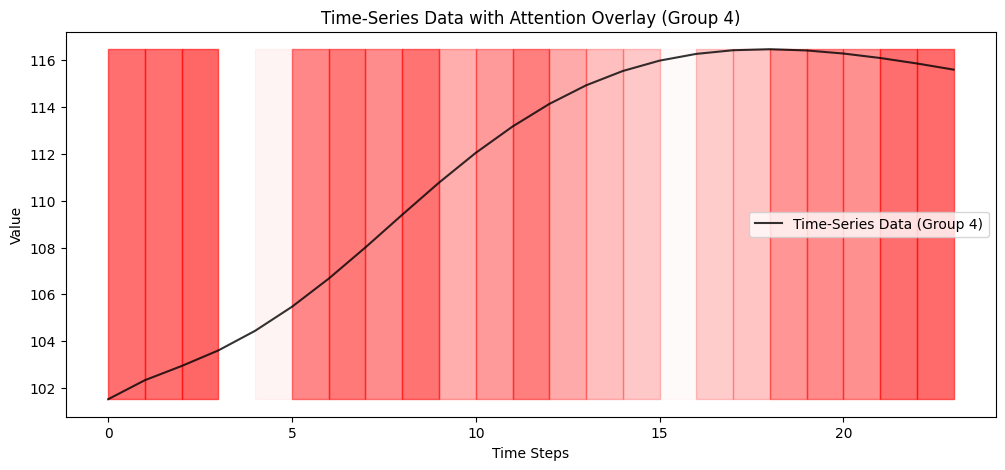

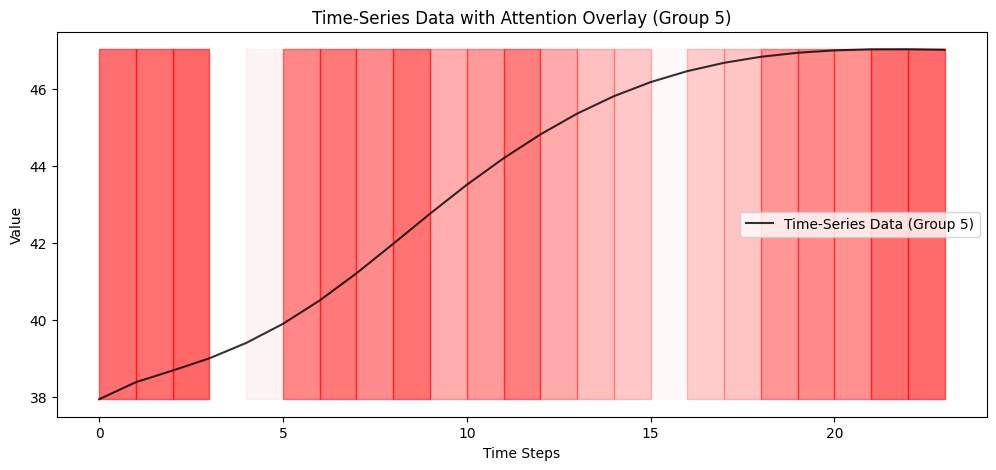

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_overlay_per_group(time_series, attention_scores, group_index, group_name="Group"):
    """
    Overlays attention scores onto the time-series plot for a specific categorical ID.
    - Darker regions = higher attention.
    - Shows which time steps received more focus from the model.
    """
    fig, ax = plt.subplots(figsize=(12, 5))

    # Ensure time series and attention have matching lengths
    min_len = min(len(time_series), len(attention_scores))
    time_series = time_series[:min_len]
    attention_scores = attention_scores[:min_len]

    # Normalize attention scores (0 to 1)
    attention_scaled = (attention_scores - np.min(attention_scores)) / (np.max(attention_scores) - np.min(attention_scores) + 1e-6)

    # Ensure the red overlay varies per time step instead of filling everything
    for i in range(min_len - 1):
        ax.fill_between([i, i + 1], time_series.min(), time_series.max(),
                        color="red", alpha=attention_scaled[i] * 0.6)  # Adjust transparency dynamically

    # Plot time series
    ax.plot(time_series, color="black", alpha=0.8, label=f"Time-Series Data ({group_name})")

    ax.set_title(f"Time-Series Data with Attention Overlay ({group_name})")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Value")
    ax.legend()
    plt.show()

# Extract attention weights correctly
attention_scores = interpretation["attention"].detach().cpu().numpy() if hasattr(interpretation["attention"], "detach") else np.array(interpretation["attention"])

# Extract actual time-series predictions correctly (selecting the first quantile)
group_count = 5  # Since you have 5 categorical IDs
time_series_data = pred.output["prediction"][:, :, 0].detach().cpu().numpy()  # First quantile

# Plot each group separately
for group_idx in range(group_count):
    plot_attention_overlay_per_group(time_series_data[group_idx], attention_scores, group_idx, group_name=f"Group {group_idx+1}")


In [11]:
pred.output['prediction'].shape

torch.Size([5, 24, 7])

In [12]:
interpretation = tft.interpret_output(pred.output, reduction="sum")


In [13]:
interpretation['attention'].shape

torch.Size([168])

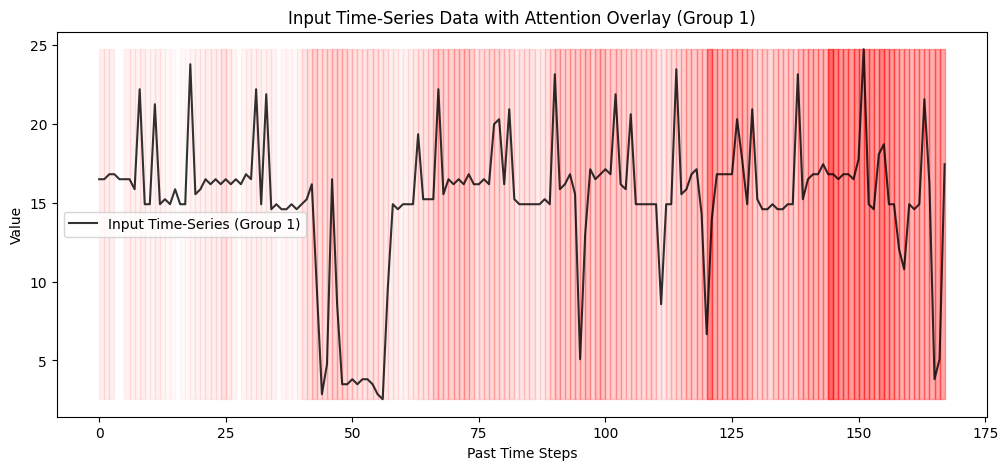

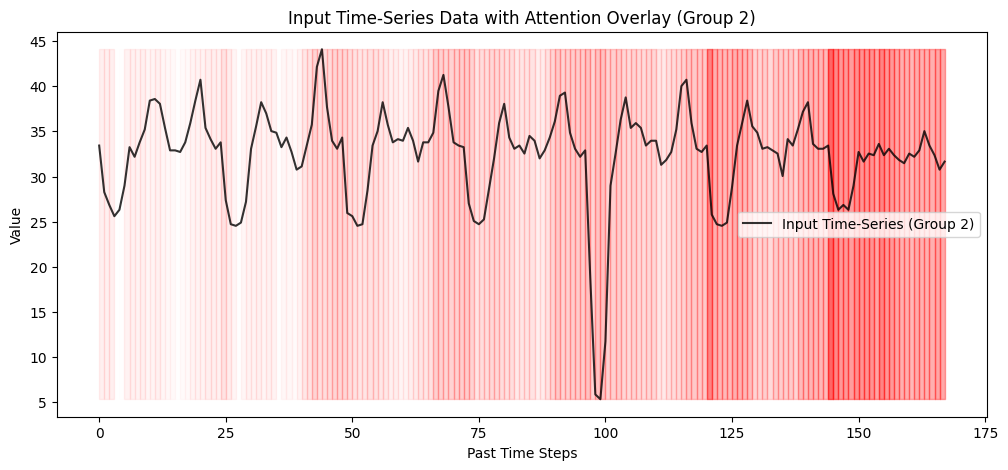

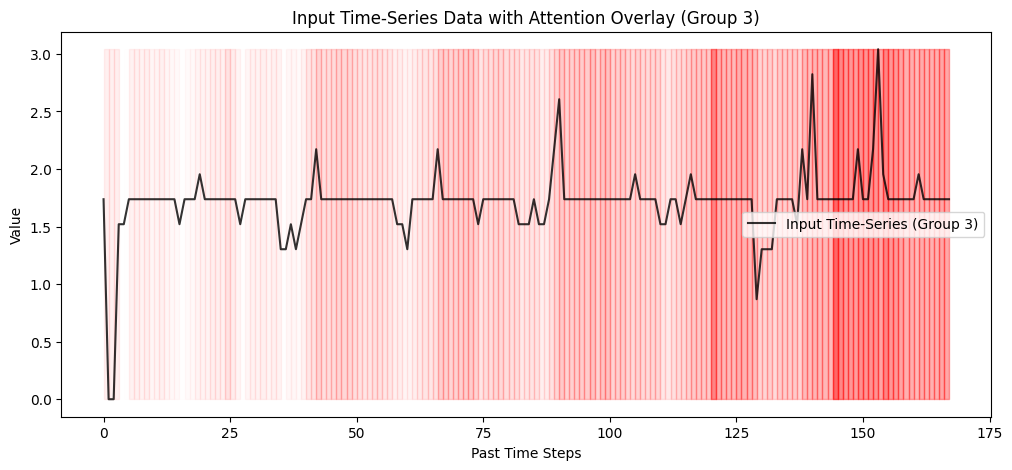

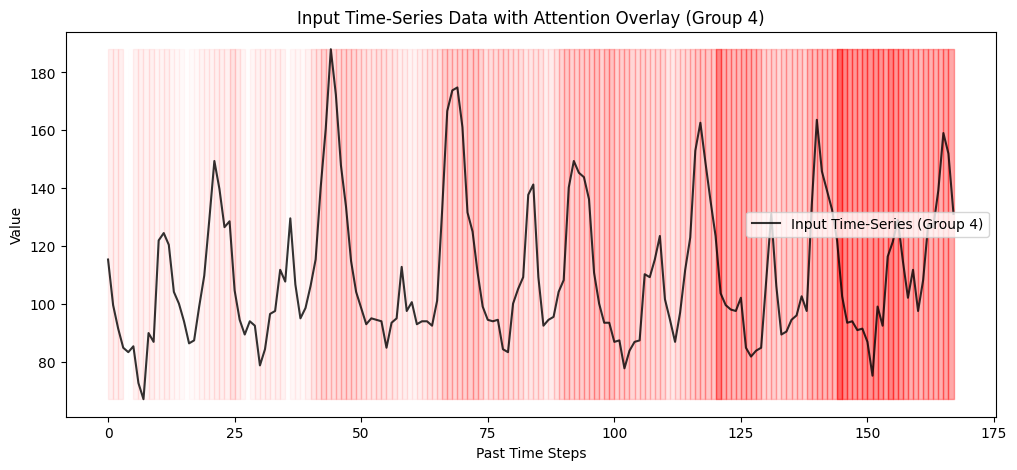

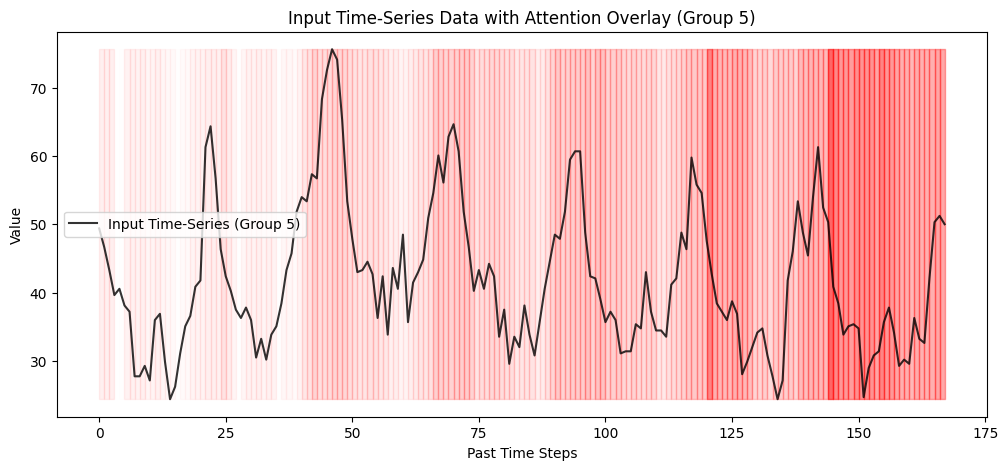

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_overlay_on_input(input_series, attention_scores, group_index, group_name="Categorical_ID: "):
    """
    Overlays attention scores onto the input time-series plot (historical data).
    - Darker regions = higher attention.
    - Shows which past time steps the model attended to most.
    """
    fig, ax = plt.subplots(figsize=(12, 5))

    # Ensure time series and attention have matching lengths
    min_len = min(len(input_series), len(attention_scores))
    input_series = input_series[:min_len]
    attention_scores = attention_scores[:min_len]

    # Normalize attention scores (0 to 1)
    attention_scaled = (attention_scores - np.min(attention_scores)) / (np.max(attention_scores) - np.min(attention_scores) + 1e-6)

    # Overlay attention on past time steps
    for i in range(min_len - 1):
        ax.fill_between([i, i + 1], input_series.min(), input_series.max(),
                        color="red", alpha=attention_scaled[i] * 0.6)  # Adjust transparency dynamically

    # Plot actual input time-series data
    ax.plot(input_series, color="black", alpha=0.8, label=f"Input Time-Series ({group_name})")

    ax.set_title(f"Input Time-Series Data with Attention Overlay ({group_name})")
    ax.set_xlabel("Past Time Steps")
    ax.set_ylabel("Value")
    ax.legend()
    plt.show()

# Extract attention weights (which apply to historical time steps)
attention_scores = interpretation["attention"].detach().cpu().numpy() if hasattr(interpretation["attention"], "detach") else np.array(interpretation["attention"])

# Extract the corresponding **input time series** (not output predictions!)
group_count = 5  # Since you have 5 categorical IDs
input_series_data = pred.x["encoder_target"].detach().cpu().numpy()  # Selecting first target variable from input

# Plot each group's attention overlay
for group_idx in range(group_count):
    plot_attention_overlay_on_input(input_series_data[group_idx], attention_scores, group_idx, group_name=f"Group {group_idx+1}")


In [15]:
# Print model structure to find attention layers
print(tft)


TemporalFusionTransformer(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'hours_from_start', 'target': 'power_usage', 'group_ids': ['categorical_id'], 'weight': None, 'max_encoder_length': 168, 'min_encoder_length': 168, 'min_prediction_idx': np.int64(26304), 'min_prediction_length': 24, 'max_prediction_length': 24, 'static_categoricals': ['categorical_id'], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['hours_from_start', 'day', 'day_of_week', 'month', 'hour'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['power_usage'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': False, 'lags': None, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': True, 'target_normalizer': GroupNormalizer(
  		method='standard',
  		grou

In [16]:
tft.multihead_attn


InterpretableMultiHeadAttention(
  (dropout): Dropout(p=0.1, inplace=False)
  (v_layer): Linear(in_features=8, out_features=2, bias=True)
  (q_layers): ModuleList(
    (0-3): 4 x Linear(in_features=8, out_features=2, bias=True)
  )
  (k_layers): ModuleList(
    (0-3): 4 x Linear(in_features=8, out_features=2, bias=True)
  )
  (attention): ScaledDotProductAttention(
    (softmax): Softmax(dim=2)
  )
  (w_h): Linear(in_features=2, out_features=8, bias=False)
)

In [17]:
import numpy as np


def quantile_loss(y_true, y_pred, q):
    """
    Compute the quantile loss.

    Args:
        y_true (array-like): Actual values.
        y_pred (array-like): Predicted quantile values.
        q (float): Quantile, e.g., 0.5 for P50, 0.9 for P90.

    Returns:
        float: Quantile loss.
    """
    errors = y_true - y_pred
    return np.mean(np.maximum(q * errors, (q - 1) * errors))

raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

# Assuming raw_predictions.output.prediction contains your predictions
predictions = raw_predictions.output.prediction

# Extract P50 (median) and P90 (90th percentile) predictions
y_pred_p50 = predictions[:, :, 3].detach().cpu().numpy()  # P50 is usually at index 1
y_pred_p90 = predictions[:, :, 5].detach().cpu().numpy()  # P90 is usually at index 2

y_true = raw_predictions.x['decoder_target'].detach().cpu().numpy()

raw_predictions.output['encoder_attention']


# Compute losses
p50_loss = quantile_loss(y_true, y_pred_p50, q=0.5)
p90_loss = quantile_loss(y_true, y_pred_p90, q=0.9)

print(f"P50 Loss: {p50_loss:.4f}")
print(f"P90 Loss: {p90_loss:.4f}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


P50 Loss: 5.6456
P90 Loss: 3.4825


/home/ubuntu/myenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.



{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x375 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

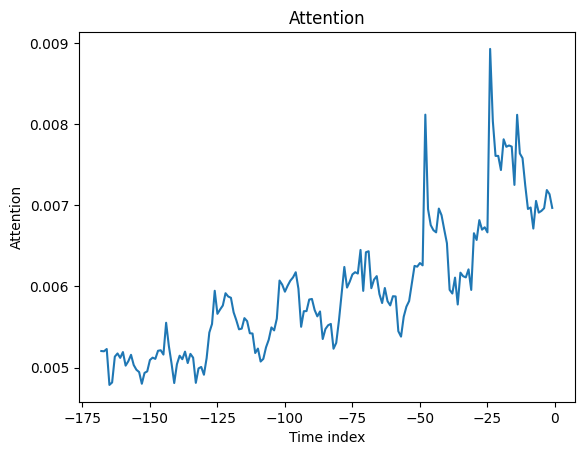

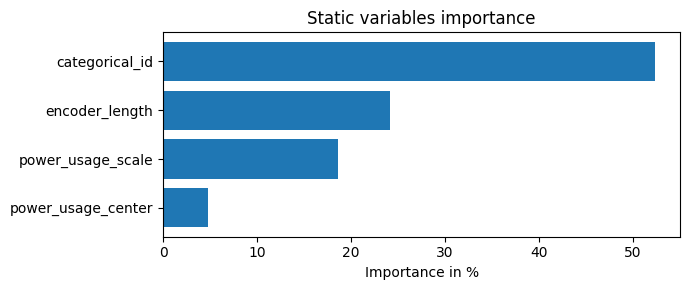

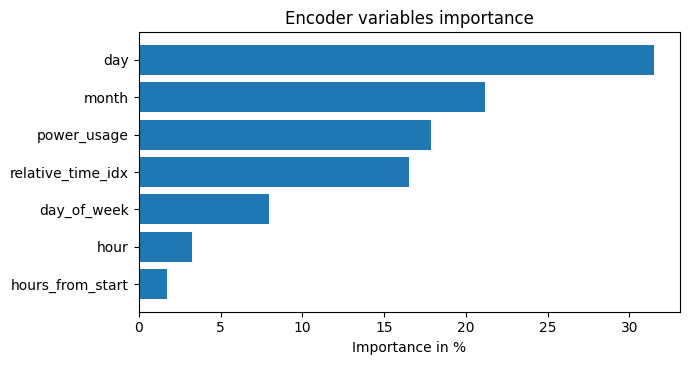

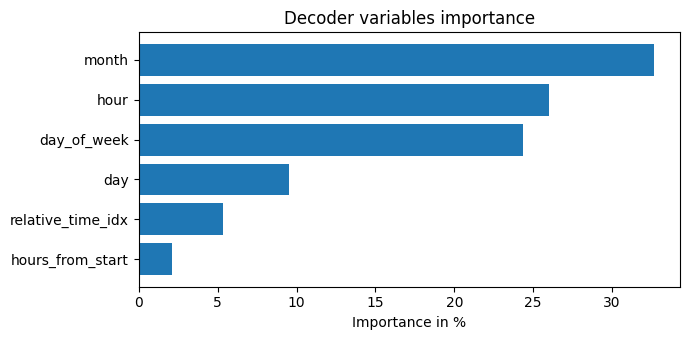

In [18]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)

In [19]:
pred = tft.predict(val_dataloader, mode="raw", return_x=True).output


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/myenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.



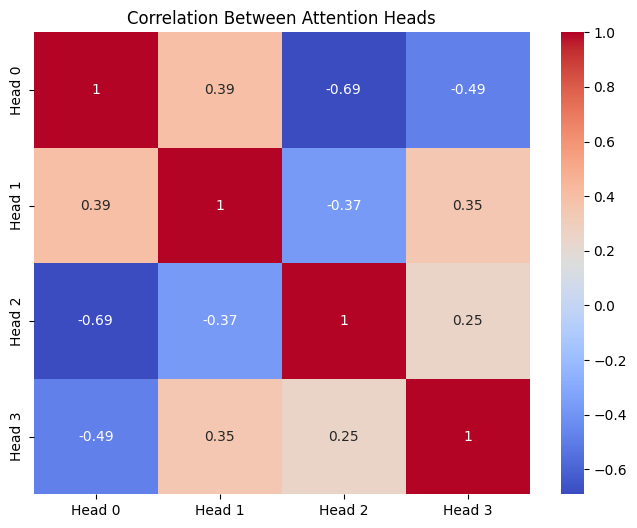

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def compute_head_correlation(pred):
    """
    Computes correlation between attention heads to identify redundancy.
    """
    encoder_attention = pred.encoder_attention.detach().cpu().numpy()  # Shape: (batch_size, decoder_length, num_heads, encoder_length)
    
    # Average over batch and decoder time steps
    avg_attention = np.mean(encoder_attention, axis=(0, 1))  # Shape: (num_heads, encoder_length)

    # Compute correlation matrix across heads
    correlation_matrix = np.corrcoef(avg_attention)  # Shape: (num_heads, num_heads)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=[f"Head {i}" for i in range(avg_attention.shape[0])], 
                yticklabels=[f"Head {i}" for i in range(avg_attention.shape[0])])
    plt.title("Correlation Between Attention Heads")
    plt.show()

    return correlation_matrix

# Compute correlation between heads
correlation_matrix = compute_head_correlation(pred)


In [21]:
import numpy as np

def get_attention_variance(pred):
    """
    Computes variance for each attention head.
    Returns a list of head indices sorted from least to most important.
    """
    encoder_attention = pred.encoder_attention.detach().cpu().numpy()  # Shape: (5, 24, 4, 168)
    
    # Compute variance per head (mean over batch & time steps)
    attention_variance = np.var(encoder_attention, axis=(0, 1, 3))  # Variance per head
    
    # Sort heads from least to most important (low variance = redundant)
    sorted_heads = np.argsort(attention_variance)

    return sorted_heads, attention_variance

# Identify least informative heads
sorted_heads, head_variances = get_attention_variance(pred)
print("Heads ranked from least to most important (by variance):", sorted_heads)
print("Variance per head:", head_variances)


Heads ranked from least to most important (by variance): [1 3 2 0]
Variance per head: [7.0318897e-06 9.5668963e-07 4.8927377e-06 2.5762365e-06]


In [22]:
import torch

def prune_attention_heads(tft, head_indices_to_prune):
    """
    Prune specific attention heads by setting their weights to zero.
    :param tft: Trained TemporalFusionTransformer model
    :param head_indices_to_prune: List of attention heads to remove (e.g., [1, 3])
    """
    with torch.no_grad():  # Disable gradient updates during pruning
        for head in head_indices_to_prune:
            # Set query layer (Q) to zero for the head
            tft.multihead_attn.q_layers[head].weight.zero_()
            tft.multihead_attn.q_layers[head].bias.zero_()
            
            # Set key layer (K) to zero for the head
            tft.multihead_attn.k_layers[head].weight.zero_()
            tft.multihead_attn.k_layers[head].bias.zero_()
        
        print(f"Pruned heads: {head_indices_to_prune}")

# Example: Remove heads 1 and 3
prune_attention_heads(tft, [1, 3])


Pruned heads: [1, 3]


In [23]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

# Assuming raw_predictions.output.prediction contains your predictions
predictions = raw_predictions.output.prediction

# Extract P50 (median) and P90 (90th percentile) predictions
y_pred_p50 = predictions[:, :, 3].detach().cpu().numpy()  # P50 is usually at index 1
y_pred_p90 = predictions[:, :, 5].detach().cpu().numpy()  # P90 is usually at index 2

y_true = raw_predictions.x['decoder_target'].detach().cpu().numpy()

# Compute losses
p50_loss = quantile_loss(y_true, y_pred_p50, q=0.5)
p90_loss = quantile_loss(y_true, y_pred_p90, q=0.9)

print(f"P50 Loss: {p50_loss:.4f}")
print(f"P90 Loss: {p90_loss:.4f}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


P50 Loss: 5.6458
P90 Loss: 3.4817


/home/ubuntu/myenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.



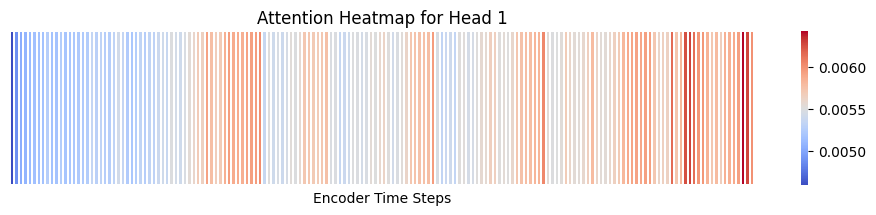

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_attention_heatmap(pred, head_idx):
    """
    Plots an attention heatmap for a specific attention head.
    """
    encoder_attention = pred.encoder_attention.detach().cpu().numpy()  # (5, 24, 4, 168)
    
    # Average over batch & decoder time steps
    avg_attention = np.mean(encoder_attention[:, :, head_idx, :], axis=(0, 1))  # Now shape (168,)

    # Reshape to a 2D attention map (self-attention structure)
    avg_attention = avg_attention.reshape(1, -1)  # Convert to (1, 168) for proper plotting

    # Plot heatmap
    plt.figure(figsize=(12, 2))  # Adjusted for 1D attention
    sns.heatmap(avg_attention, cmap="coolwarm", xticklabels=False, yticklabels=False, linewidths=0.2)
    plt.title(f"Attention Heatmap for Head {head_idx}")
    plt.xlabel("Encoder Time Steps")
    plt.show()

# Example: Plot heatmap for the least important head
plot_attention_heatmap(pred, sorted_heads[0])


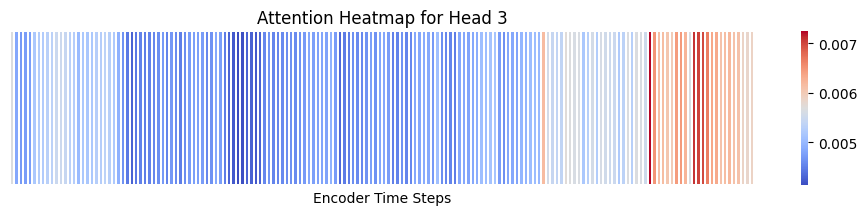

In [25]:
plot_attention_heatmap(pred, sorted_heads[1])


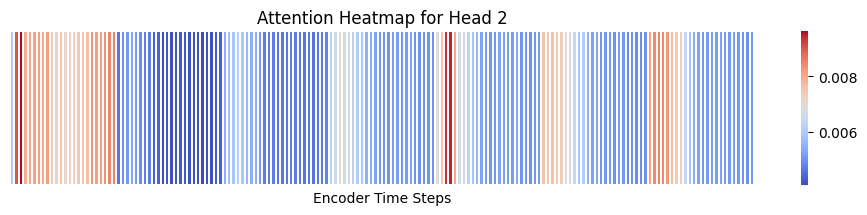

In [26]:
plot_attention_heatmap(pred, sorted_heads[2])


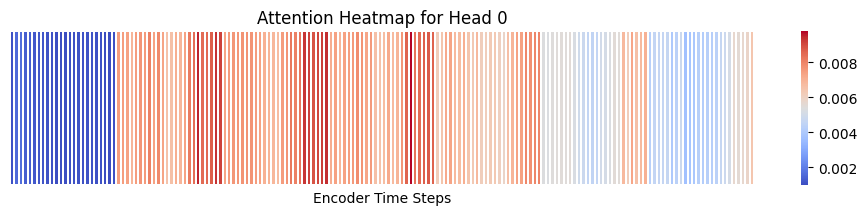

In [27]:
plot_attention_heatmap(pred, sorted_heads[3])


In [28]:
from copy import deepcopy
import torch

import torch

def prune_attention_heads(tft, head_indices_to_prune):
    """
    Prune specific attention heads by setting their weights to zero.
    :param tft: Trained TemporalFusionTransformer model
    :param head_indices_to_prune: List of attention heads to remove (e.g., [1, 3])
    """
    with torch.no_grad():  # Disable gradient updates during pruning
        for head in head_indices_to_prune:
            # Set query layer (Q) to zero for the head
            tft.multihead_attn.q_layers[head].weight.zero_()
            tft.multihead_attn.q_layers[head].bias.zero_()
            
            # Set key layer (K) to zero for the head
            tft.multihead_attn.k_layers[head].weight.zero_()
            tft.multihead_attn.k_layers[head].bias.zero_()
        
        print(f"Pruned heads: {head_indices_to_prune}")

def evaluate_model(tft, val_dataloader):
    """
    Evaluates the model using P50 loss.
    """
    tft.eval()  # Set to evaluation mode
    
    with torch.no_grad():
        raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)
    
    # Extract P50 predictions
    predictions = raw_predictions.output.prediction
    y_pred_p50 = predictions[:, :, 3].detach().cpu().numpy()
    y_true = raw_predictions.x['decoder_target'].detach().cpu().numpy()
    
    # Compute P50 loss
    p50_loss = quantile_loss(y_true, y_pred_p50, q=0.5)

    return {"P50 Loss": p50_loss}

def evaluate_performance_change(tft, val_dataloader, pred):
    """
    Prunes each attention head one by one and measures the P50 loss change.
    """
    original_metrics = evaluate_model(tft, val_dataloader)  # Baseline P50 loss
    head_importance = {}

    for head in range(pred.encoder_attention.shape[2]):  # Loop through all heads
        tft_copy = deepcopy(tft)  # Copy model to avoid modifying original
        prune_attention_heads(tft_copy, [head])  # Prune one head
        pruned_metrics = evaluate_model(tft_copy, val_dataloader)  # Evaluate
        
        print(pruned_metrics)
        
        # Compute performance drop
        loss_change = original_metrics["P50 Loss"] - pruned_metrics["P50 Loss"]
        head_importance[head] = loss_change

    return head_importance

# Get head importance scores
head_importance_scores = evaluate_performance_change(tft, val_dataloader, pred)

# Sort heads by highest P50 loss drop (most important first)
sorted_heads_by_importance = sorted(head_importance_scores, key=lambda x: head_importance_scores[x], reverse=True)

print("Heads ranked from most important to least important (by P50 loss drop):", sorted_heads_by_importance)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/myenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Pruned heads: [0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'P50 Loss': np.float32(5.646939)}
Pruned heads: [1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'P50 Loss': np.float32(5.645802)}
Pruned heads: [2]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'P50 Loss': np.float32(5.646156)}
Pruned heads: [3]
{'P50 Loss': np.float32(5.645802)}
Heads ranked from most important to least important (by P50 loss drop): [1, 3, 2, 0]


In [29]:
from itertools import combinations
from copy import deepcopy

def evaluate_head_combinations(tft, val_dataloader, pred, num_combinations=5):
    """
    Prunes different combinations of heads and evaluates P50 loss.
    """
    original_metrics = evaluate_model(tft, val_dataloader)  # Baseline metrics
    head_combinations = list(combinations(range(pred.encoder_attention.shape[2]), 2))  # Generate head pairs
    head_importance = {}

    for comb in head_combinations[:num_combinations]:  # Try top N combinations
        tft_copy = deepcopy(tft)
        prune_attention_heads(tft_copy, list(comb))
        pruned_metrics = evaluate_model(tft_copy, val_dataloader)

        # Compute performance change
        loss_change = original_metrics["P50 Loss"] - pruned_metrics["P50 Loss"]
        head_importance[comb] = loss_change

    return head_importance

# Get importance scores for head pairs
head_pair_importance = evaluate_head_combinations(tft, val_dataloader, pred)

# Print top combinations that least affect performance (least loss change)
sorted_head_pairs = sorted(head_pair_importance, key=lambda x: head_pair_importance[x])
print("Most redundant head pairs (least impact on loss when pruned):", sorted_head_pairs[:5])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Pruned heads: [0, 1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Pruned heads: [0, 2]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Pruned heads: [0, 3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Pruned heads: [1, 2]
Pruned heads: [1, 3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Most redundant head pairs (least impact on loss when pruned): [(0, 2), (0, 1), (0, 3), (1, 2), (1, 3)]


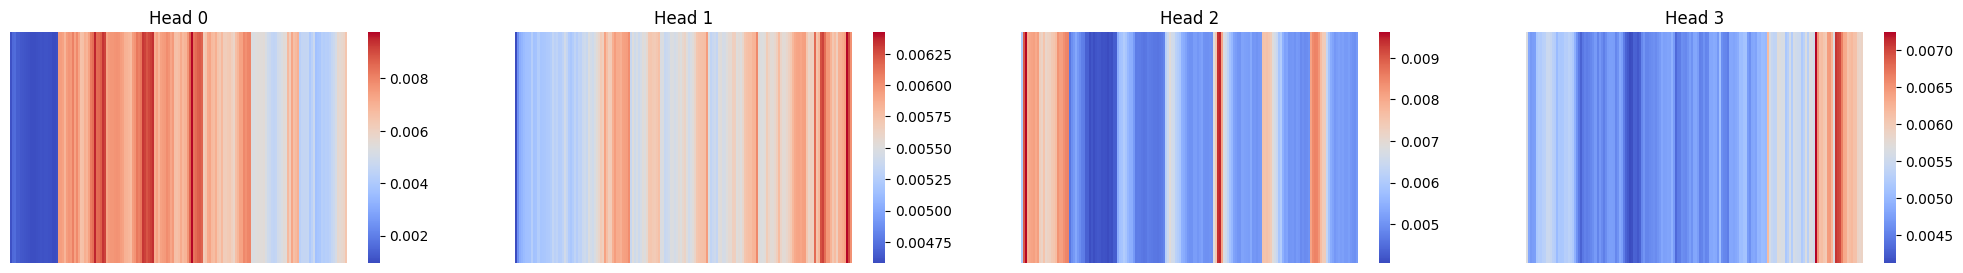

In [31]:
def plot_multiple_attention_heatmaps(pred, head_indices):
    """
    Plots multiple attention heatmaps for comparison.
    """
    fig, axes = plt.subplots(1, len(head_indices), figsize=(25, 3))

    for idx, head_idx in enumerate(head_indices):
        encoder_attention = pred.encoder_attention.detach().cpu().numpy()
        avg_attention = np.mean(encoder_attention[:, :, head_idx, :], axis=(0, 1))  # (encoder_length,)

        avg_attention = avg_attention.reshape(1, -1)  # (1, encoder_length)

        sns.heatmap(avg_attention, ax=axes[idx], cmap="coolwarm", xticklabels=False, yticklabels=False)
        axes[idx].set_title(f"Head {head_idx}")

    plt.show()

# Example: Compare two heads
plot_multiple_attention_heatmaps(pred, [0, 1, 2, 3])
